# Разработка A/B-тестирования и анализ результатов

Есть развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В  приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Нужно рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Данные представлены тремя таблицами:

- таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 

- таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц 


## Задачи: 

рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных


In [1]:
import pandas as pd

sessions_history = pd.read_csv('1')

display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными



In [2]:
display(sessions_history['session_id'].nunique())
display(sessions_history['session_id'].shape[0])
#Проверка того что нет повторяющихся идентификаторовв сессий

435924

435924

In [3]:
df_count_sess = sessions_history['user_id'].value_counts().sort_values(ascending=False)
display(df_count_sess.index[0])
#нашли пользователя с кол-ввом посещений 10 вобще их два, про сути можно было и по столбццу session_number определить

'6A73CB5566BB494D'

In [4]:
display(sessions_history[sessions_history['user_id']==df_count_sess.index[0]])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций


In [5]:
sessions_history_grp = sessions_history.groupby('session_date').agg({
        'user_id': 'count',
        'registration_flag': 'sum'
    }).reset_index()
display(sessions_history_grp.head())

,session_date,user_id,registration_flag
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


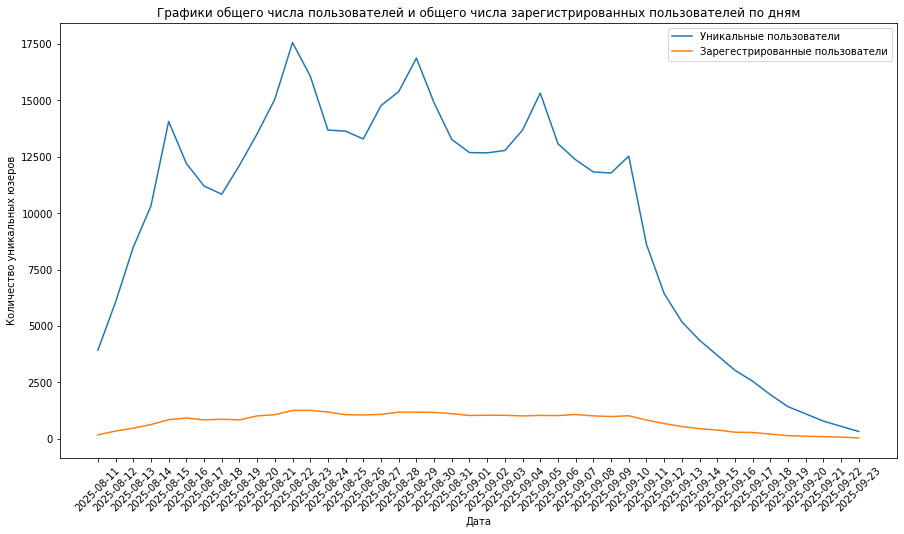

In [6]:
import matplotlib.pyplot as plt

x = sessions_history_grp['session_date']
y_a = sessions_history_grp['user_id']
y_b = sessions_history_grp['registration_flag']

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='Уникальные пользователи')
plt.plot(x, y_b,label ='Зарегестрированные пользователи')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество уникальных юзеров")
plt.legend()
plt.title('Графики общего числа пользователей и общего числа зарегистрированных пользователей по дням')
plt.show()

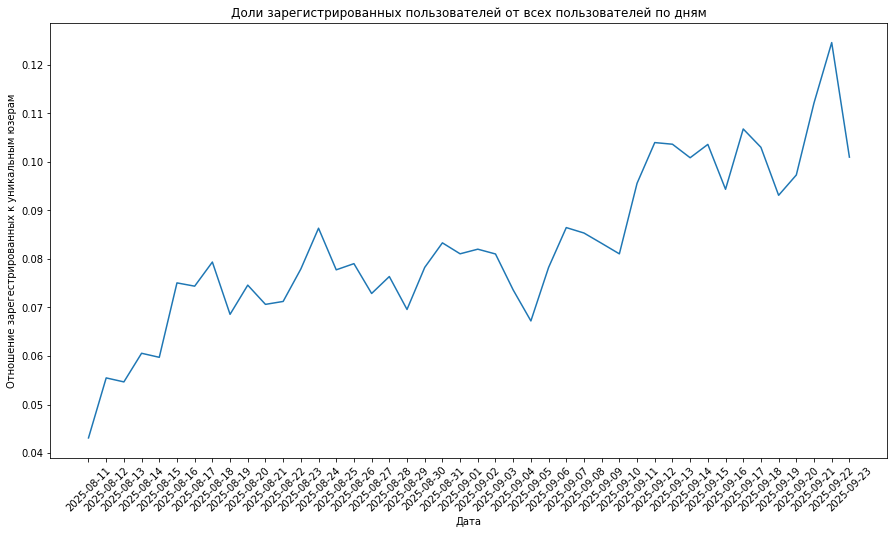

In [7]:
x = sessions_history_grp['session_date']
y = sessions_history_grp['registration_flag'] / sessions_history_grp['user_id']

plt.figure(figsize=(15, 8))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Отношение зарегестрированных к уникальным юзерам")
plt.title('Доли зарегистрированных пользователей от всех пользователей по дням')
plt.show()

#### 1.4. Анализ числа просмотренных страниц


In [8]:
sessions_history_grp_1 = sessions_history.groupby('page_counter').agg({
        'session_id': 'count',
    })
display(sessions_history_grp_1)

,session_id
page_counter,
1,29160
2,105536
3,166690
4,105569
5,26288
6,2589
7,92


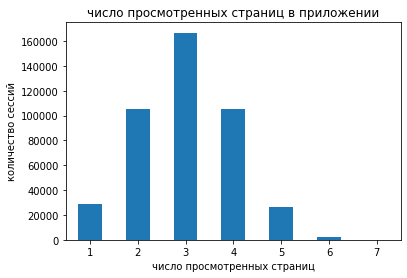

In [9]:
sessions_history_grp_1.plot(kind='bar',
                title='число просмотренных страниц в приложении',
                legend=False,
                ylabel='количество сессий',
                xlabel='число просмотренных страниц',
                rot=0)
plt.show() 

#### 1.5. Доля пользователей, просмотревших более четырёх страниц


In [10]:
def calc_good(row):
    if row['page_counter'] >= 4:
        return 1
    else: 
        return 0

sessions_history['good_session'] = sessions_history.apply(calc_good, axis=1)


In [11]:
sessions_history_grp_2 = sessions_history.groupby('session_date').agg({
        'session_id': 'count',
        'good_session': 'sum'
    }).reset_index()


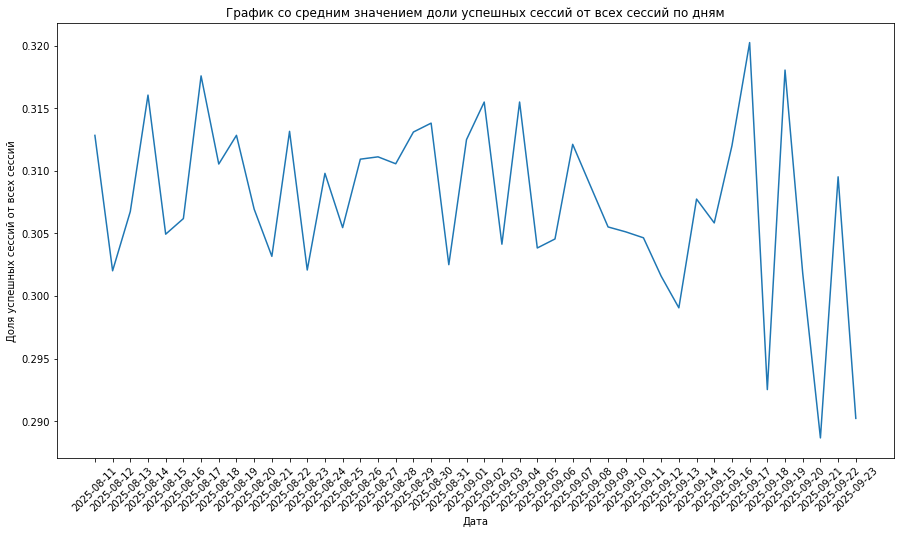

In [12]:

x = sessions_history_grp_2['session_date']
y = sessions_history_grp_2['good_session'] / sessions_history_grp_2['session_id']

plt.figure(figsize=(15, 8))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий от всех сессий")
plt.title('График со средним значением доли успешных сессий от всех сессий по дням')
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез


Целеввая метрика - доля успешных сессий

Если обозначить за {μa, μb} средние значения метрики на генеральной совокупности для групп A и B соответственно, то статистические гипотезы будут выглядеть так:
Нулевая гипотеза H0: μa = μb
Альтернативная гипотеза H1: μa < μb

#### 2.2. Расчёт размера выборки

параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%.


In [13]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста


In [14]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history_grp['user_id'].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size)*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.


In [15]:
sessions_test_part = pd.read_csv('2')
group_a = sessions_test_part[sessions_test_part['test_group'] == "A"]['user_id'].nunique()
group_b = sessions_test_part[sessions_test_part['test_group'] == "B"]['user_id'].nunique()
display(group_a, group_b)

1477

1466

In [16]:
P = round(100*abs(group_a - group_b)/group_a,2)
display(P)

0.74

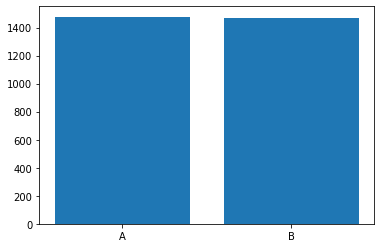

In [17]:
plt.bar(['A', 'B'], [group_a, group_b ]) 
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.


In [18]:
A_count = sessions_test_part[sessions_test_part['test_group'] == "A"]['user_id'].count()
B_count = sessions_test_part[sessions_test_part['test_group'] == "B"]['user_id'].count()
Other_count = sessions_test_part[(sessions_test_part['test_group'] != "B")&(sessions_test_part['test_group'] != "A")]['user_id'].count()
Total_count = sessions_test_part['user_id'].count()
display(Total_count - A_count - B_count - Other_count)

0

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.


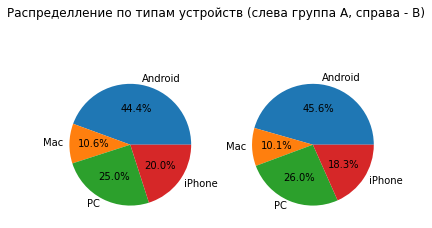

In [19]:
sessions_test_part_grp_ab_dev = sessions_test_part.groupby([ 'device','test_group'])['user_id'].nunique().unstack(fill_value=0)
sessions_test_part_grp_ab_dev.plot(kind='pie',
                title='Распределление по типам устройств (слева группа А, справа - В)',
                legend=False,
                autopct='%1.1f%%',
                ylabel='',
                xlabel='',
                subplots=True,
                rot=0)

plt.show() 


В целом визульно распределение пользователей по устройствам совпадает 

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.



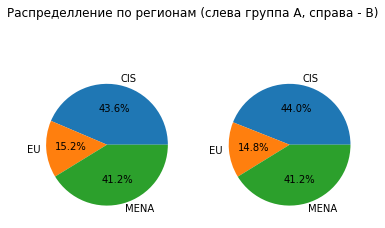

In [20]:
sessions_test_part_grp_ab_reg = sessions_test_part.groupby([ 'region','test_group'])['user_id'].nunique().unstack(fill_value=0)
sessions_test_part_grp_ab_reg.plot(kind='pie',
               title='Распределление по регионам (слева группа А, справа - В)',
                legend=False,
                autopct='%1.1f%%',
                ylabel='',
                xlabel='',
                subplots=True)

plt.show() 

В целом визульно распределение пользователей по регионам совпадает

#### 3.5. Вывод после проверки A/B-теста


Различие в количестве пользователей в двух группах обнаружено было процентная разница 0,74 это очень мало что значит все хорошо
Выборки явлеются независимыми, пересечение пользователей из тестовой и контрольной групп не было обнаружено
равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам сохраняется
A/B-тест прооходит корректно!


### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нкас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики


In [21]:
sessions_test = pd.read_csv('3')
sessions_test['good_session'] = sessions_test.apply(calc_good, axis=1)
display(sessions_test.head())

sessions_test['user_id'].nunique()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


30579

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и сравниваются две сопоставимые группы.



In [22]:
sessions_test_grp = sessions_test.groupby(['session_date', 'test_group'])['session_id'].count().unstack(fill_value=0).reset_index()
display(sessions_test_grp)

test_group,session_date,A,B
0,2025-10-14,1502,1628
1,2025-10-15,2235,2283
2,2025-10-16,3280,3241
3,2025-10-17,4089,4054
4,2025-10-18,5013,5059
5,2025-10-19,6535,6779
6,2025-10-20,5837,6089
7,2025-10-21,3927,3981
8,2025-10-22,3083,3111
9,2025-10-23,2470,2548


In [23]:
from scipy.stats import ttest_ind
sample_a = sessions_test_grp['A']
sample_b = sessions_test_grp[ 'B']

test_result = ttest_ind(
    sample_a,
    sample_b,
    alternative='two-sided' 
)
alpha = 0.05
if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу') 

pvalue=0.938219304859116 > 0.05
Не получилось отвергнуть нулевую гипотезу


Это значит что кол-во уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми

#### 4.3. Сравнение доли успешных сессий


In [24]:
sessions_test_grp_good = sessions_test.groupby('test_group').agg({
        'session_id': 'count',
        'good_session': 'sum'
    })
sessions_test_grp_good['part'] = sessions_test_grp_good['good_session'] / sessions_test_grp_good['session_id']
display(sessions_test_grp_good)
display((sessions_test_grp_good['part']['B'] - sessions_test_grp_good['part']['A'])*100)

,session_id,good_session,part
test_group,,,
A,49551,15248,0.307723
B,50454,16059,0.318290


1.0566571724179463

#### 4.4. Насколько статистически значимо изменение ключевой метрики



In [25]:
sample_a = sessions_test[sessions_test['test_group']=='A']['good_session']
sample_b = sessions_test[sessions_test['test_group']=='B']['good_session']

test_result = ttest_ind(
    sample_a,
    sample_b,
    alternative='less' 
)
alpha = 0.05
if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу') 

pvalue=0.00015743044979290915 < 0.05
Отвергаем нулевую гипотезу


#### 4.5. Вывод по результатам A/B-эксперимента


Эксперимент длился 20 дней, в нем участвовало 30579 пользователей, число пользователей для двух выборок мы сократили почти в два раза ибо реккомендуемое число около 40к, однако мы увеличили время теста больше чем в два раза с 9 дней до 20 чтобы компенсировать потерю точноси, уровень значимости в эксперименте был выбран на уровне 0.05, Вероятность ошибки второго рода — 0.2, MDE — 3%
При этом пересечений данныыхъ не наблюдалось, все пользоватеели в двух категориях, среди категориальных параметров таких как регион, и устройство распределены равномерно
Да, повилияло. Был замечен рост ключеввой метрикки на 1,1%
Значение pvalue=0.00016 < 0.05, что означает что альтернатинввая гипотеза подтверждена
Внедрять ноововввеедение в приложение стоит!